In [52]:
import pandas as pd    
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
import numpy.typing as npt
import math
import re
%matplotlib inline

In [53]:
path = r'C:\Users\Ilya\Documents\GitHub\Pet_Projects\Parsing\dataframes'

In [89]:
mtgtrade_df = pd.read_csv(path +'/mtgtrade_parsing.csv')
scryfall_df = pd.read_csv(path +'/scryfall_parsing.csv')
mtg_sets_df = pd.read_excel(path +'/MTG_sets.xlsx', date_parser = pd.to_datetime)
mtg_abilities = pd.read_excel(path +'/MTG_abilities.xlsx', sheet_name='Ability').values.tolist()
mtg_ability_word = pd.read_excel(path +'/MTG_abilities.xlsx', sheet_name='Ability_words').values.tolist()
mtg_actions = pd.read_excel(path +'/MTG_abilities.xlsx', sheet_name='Action').values.tolist()

In [ ]:
scryfall_df.drop_duplicates(inplace = True)
mtgtrade_df.drop_duplicates(inplace = True)

In [56]:
mtgtrade_df['Name'] = mtgtrade_df[['Language', 'Name1', 'Name2']].apply(lambda x: x['Name1'] if x['Language'] == 'Английский' else x['Name2'], axis = 1)

In [57]:
# def isEnglish(s):
#     '''
#     Проверяем, какой из текстов на английском
#     '''
#     try:
#         s.encode(encoding='utf-8').decode('ascii')
#     except UnicodeDecodeError:
#         return False
#     else:
#         return True

In [58]:
# mtgtrade_df['English Special'] = mtgtrade_df[['Language', 'Special1', 'Special2']].apply(lambda x: x['Special1'] if isEnglish(x['Language']) else x['Special2'], axis = 1)

In [59]:
df = mtgtrade_df.merge(scryfall_df, on = 'Name')

In [60]:
df = df.merge(mtg_sets_df,left_on='Set', right_on='Name')

In [61]:
card_types = ['basic land', 'artifact creature', 'creature', 'instant', 'sorcery', 'enchantment creature', 'enchantment', 'land', 
             'artifact',  'planeswalker']

In [62]:
def corrected_type(main_type: str) -> str:
    '''
    Преобразует типы карт в укрупненные группы
    '''
    cor_type = 'other'
    for card_type in card_types:
        if card_type in main_type.lower():
            cor_type = card_type
            break
    return cor_type

In [63]:
df['Main type'] = df['Main type'].map(corrected_type)

In [64]:
df = df[df['Price'].isna() == False]

In [65]:
df['Price']= df['Price'].apply(lambda x: x if x.find('\n') == -1 else x.split('\n')[1])
df['Price'] = df['Price'].str.replace(' ₽','').astype(int)
df['Qty']= df['Qty'].apply(lambda x: x if x.find('\n') == -1 else x.split('\n')[1])
df['Qty'] = df['Qty'].str.replace(' шт.','').astype(int)

In [66]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [67]:
def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

<AxesSubplot:xlabel='Month_sin', ylabel='Month_cos'>

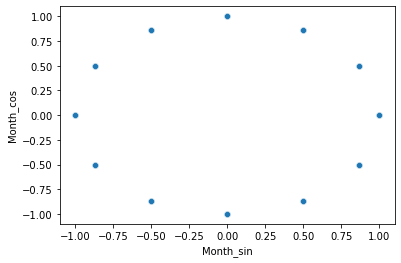

In [68]:
df["Month_cos"] = df["Month"].apply(lambda x: np.cos(x / 12 * 2 * np.pi))
df["Month_sin"] = df["Month"].apply(lambda x: np.sin(x / 12 * 2 * np.pi))
sns.scatterplot(x = df["Month_sin"], y = df["Month_cos"])

In [69]:
df['Feature length'] = df['Feature'].apply(lambda x: len(x) if type(x) != float else 0)

In [70]:
cols_to_drop = [ 'Name1', 'Name2', 'Special1', 'Special2', 'Name_y', 'Cost', 'Cost_qty']
df.drop(cols_to_drop, inplace = True, axis = 1)

In [71]:
df.loc[1]

Language                                                 Английский
Set                                                          Ixalan
Foil                                                            NaN
Quality                                                          SP
Rarity                                                   Мифическая
Price                                                           160
Qty                                                               0
Name_x                                        Admiral Beckett Brass
Type                              Legendary Creature — Human Pirate
Feature           Other Pirates you control get +1/+1.\nAt the b...
Stats                                                           3/3
Illustrator                                         Jason Rainville
Standard                                                  Not Legal
Alchemy                                                   Not Legal
Pioneer                                         

In [95]:
def ability_action_cols(df:pd.DataFrame, features:list, name:str) -> pd.DataFrame:
    for feature in features:
        print(type(feature[0]), feature[0])
        df[name+'_'+feature] = df['Feature'].apply(lambda x: 1 if feature[0] in x else 0)
    return df

In [96]:
ability_action_cols(df, mtg_abilities, 'Ability')

<class 'str'> Deathtouch


TypeError: argument of type 'float' is not iterable

In [21]:
def get_color_cost(cost:str) -> str:
    try:
        cost = cost.replace('{', '').replace('}', '')
        color = ''.join(re.findall(r'\D+', cost))
        col_len = len(color)
        if col_len == 0:
            color = 'Colorless'
        else:
            color = ''.join([''.join(sorted(set(x))) for x in color])
        noncolor = sum([int(x) for x in re.findall(r'\d+', cost)])
        total_cost = noncolor + len(color)
    except Exception:
        color = 'Other'
        total_cost = 0
    return color, total_cost

In [22]:
df['Cost'].apply(lambda x: get_color_cost(x))

KeyError: 'Cost'

In [ ]:
df['Colors_dist'], df['Color cost'] = zip(*df['Cost'].map(get_color_cost))

In [ ]:
df[['Power', 'Strength']] = df[['Power', 'Strength']].fillna(-1)

In [ ]:
df.to_csv(path + '/merged_df.csv', index = False)